# Анализ топ-5000 альбомов сайта RateYourMusic.com

## Импорты 

In [1]:
import pandas as pd
import numpy as np
import calendar
import warnings
from collections import Counter
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
%matplotlib inline
warnings.simplefilter(action='ignore')

## Загрузка и предобработка данных 

In [2]:
df = pd.read_csv('rym-top-5000/rym_clean1.csv', index_col=0)
df.head()

,position,release_name,artist_name,release_date,release_type,primary_genres,secondary_genres,descriptors,avg_rating,rating_count,review_count
1,1,OK Computer,Radiohead,1997-06-16,album,"Alternative Rock, Art Rock",NaN,"melancholic, anxious, futuristic, malevocals, ...",4.24,74027,1541
2,2,Kid A,Radiohead,2000-10-03,album,"Art Rock, Experimental Rock, Electronic","Ambient, Electronic, IDM","cold, melancholic, futuristic, anxious, atmosp...",4.23,61658,751
3,3,The Dark Side of the Moon,Pink Floyd,1973-03-23,album,"Art Rock, Progressive Rock","Psychedelic Rock, Space Rock","philosophical, atmospheric, introspective, exi...",4.21,60192,1557
4,4,Loveless,My Bloody Valentine,1991-11-11,album,"Shoegaze, Noise Pop","Dream Pop, Neo-Psychedelia","noisy, ethereal, atmospheric, romantic, love, ...",4.24,53174,1264
5,5,My Beautiful Dark Twisted Fantasy,Kanye West,2010-11-22,album,"Pop Rap, Hip Hop",Art Pop,"epic, boastful, passionate, sampling, hedonist...",4.09,52149,638


Датасет содержит следующие данные:
* position - место альбома в топе
* release_name - название альбома
* release_date - дата релиза 
* release_type - тип релиза 
* primary_genres - "основные" жанры
* secondary_genres - "второстепенные" жанры
* descriptors - термины, описывающие альбом (в дальшейшем "эпитеты")
* avg_rating - средний рейтинг пользователей
* rating_count - количество оценок
* review_count - количество рецензий

Удалим колонку "release_type", т.к. все записи принадлежат к одному типу

In [3]:
df.drop('release_type', axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          5000 non-null   int64  
 1   release_name      5000 non-null   object 
 2   artist_name       5000 non-null   object 
 3   release_date      5000 non-null   object 
 4   primary_genres    4999 non-null   object 
 5   secondary_genres  4505 non-null   object 
 6   descriptors       5000 non-null   object 
 7   avg_rating        5000 non-null   float64
 8   rating_count      5000 non-null   int64  
 9   review_count      5000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 429.7+ KB


В колонке "secondary_genres" отсутствует почти 10% значений. Решим эту проблему путем создания новой колонки, содержащей данные из колонок "primary_genres" и "secondary_genres". Также преобразуем данные из строк в списки

In [5]:
# преобразуем строки в списки
df['descriptors'] = df['descriptors'].str.replace(' ', '')
df['descriptors'] = df['descriptors'].str.split(',')
df['primary_genres'] = df['primary_genres'].str.split(', ')
df['secondary_genres'] = df['secondary_genres'].str.split(', ')

df['genres'] = df['primary_genres'].fillna("").apply(list) + df['secondary_genres'].fillna("").apply(list)

# также объединим  исполнителя и альбом
df['full_name'] = df['artist_name'] + " - " + df['release_name']

In [6]:
df['release_year'] = df['release_date'].str.split('-', expand = True)[0]

In [7]:
df.head()

,position,release_name,artist_name,release_date,primary_genres,secondary_genres,descriptors,avg_rating,rating_count,review_count,genres,full_name,release_year
1,1,OK Computer,Radiohead,1997-06-16,"[Alternative Rock, Art Rock]",NaN,"[melancholic, anxious, futuristic, malevocals,...",4.24,74027,1541,"[Alternative Rock, Art Rock]",Radiohead - OK Computer,1997
2,2,Kid A,Radiohead,2000-10-03,"[Art Rock, Experimental Rock, Electronic]","[Ambient, Electronic, IDM]","[cold, melancholic, futuristic, anxious, atmos...",4.23,61658,751,"[Art Rock, Experimental Rock, Electronic, Ambi...",Radiohead - Kid A,2000
3,3,The Dark Side of the Moon,Pink Floyd,1973-03-23,"[Art Rock, Progressive Rock]","[Psychedelic Rock, Space Rock]","[philosophical, atmospheric, introspective, ex...",4.21,60192,1557,"[Art Rock, Progressive Rock, Psychedelic Rock,...",Pink Floyd - The Dark Side of the Moon,1973
4,4,Loveless,My Bloody Valentine,1991-11-11,"[Shoegaze, Noise Pop]","[Dream Pop, Neo-Psychedelia]","[noisy, ethereal, atmospheric, romantic, love,...",4.24,53174,1264,"[Shoegaze, Noise Pop, Dream Pop, Neo-Psychedelia]",My Bloody Valentine - Loveless,1991
5,5,My Beautiful Dark Twisted Fantasy,Kanye West,2010-11-22,"[Pop Rap, Hip Hop]",[Art Pop],"[epic, boastful, passionate, sampling, hedonis...",4.09,52149,638,"[Pop Rap, Hip Hop, Art Pop]",Kanye West - My Beautiful Dark Twisted Fantasy,2010


In [8]:
df[['avg_rating','rating_count','review_count']].describe()

,avg_rating,rating_count,review_count
count,5000.000000,5000.000000,5000.00000
mean,3.540424,6083.700800,101.30200
std,0.374449,5899.645056,106.48523
min,0.620000,2169.000000,6.00000
25%,3.410000,2830.000000,44.00000
50%,3.620000,3973.000000,72.00000
75%,3.770000,6736.750000,117.00000
max,4.340000,74027.000000,1557.00000


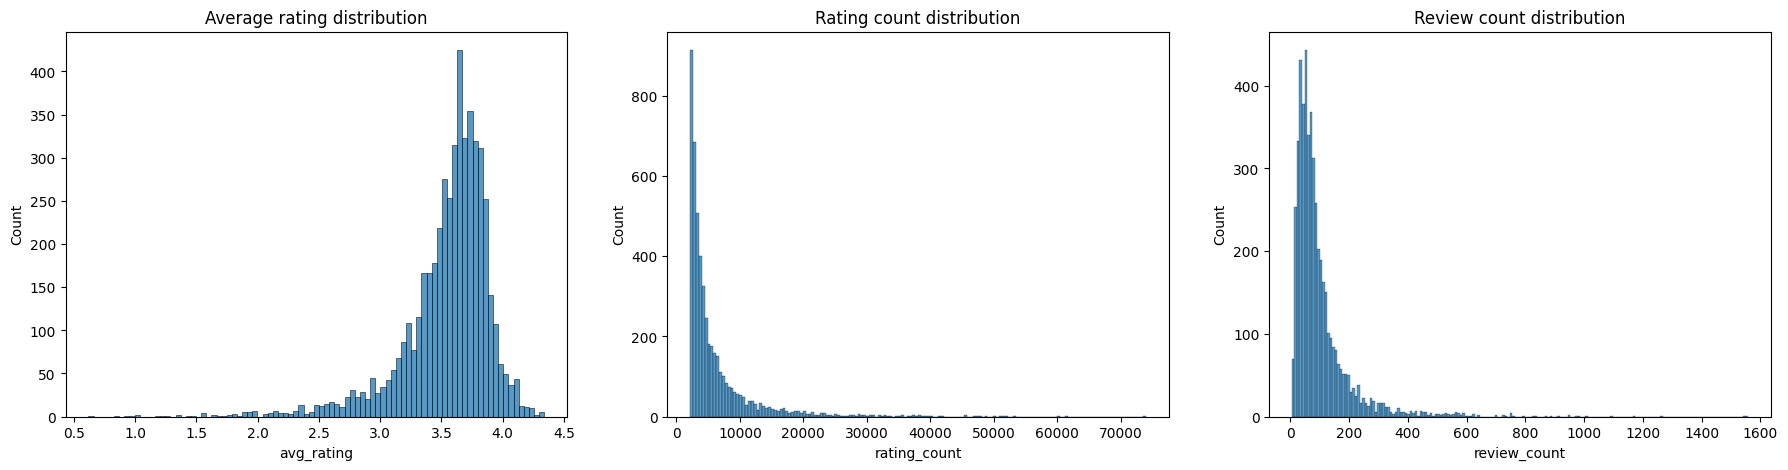

In [9]:
fig, axes = plt.subplots(1, 3, figsize=  (22, 5))
sns.histplot(ax = axes[0], data = df, x="avg_rating").set_title('Average rating distribution')
sns.histplot(ax = axes[1], data = df, x="rating_count").set_title('Rating count distribution')
sns.histplot(ax = axes[2], data = df, x="review_count").set_title('Review count distribution');

# Анализ 

**Перед анализом стоит отметить, что в силу алгоритма составления топа сайта, альбом с более высокой оценкой может занимать место ниже, чем альбом с более низкой оценкой**

## Анализ альбомов

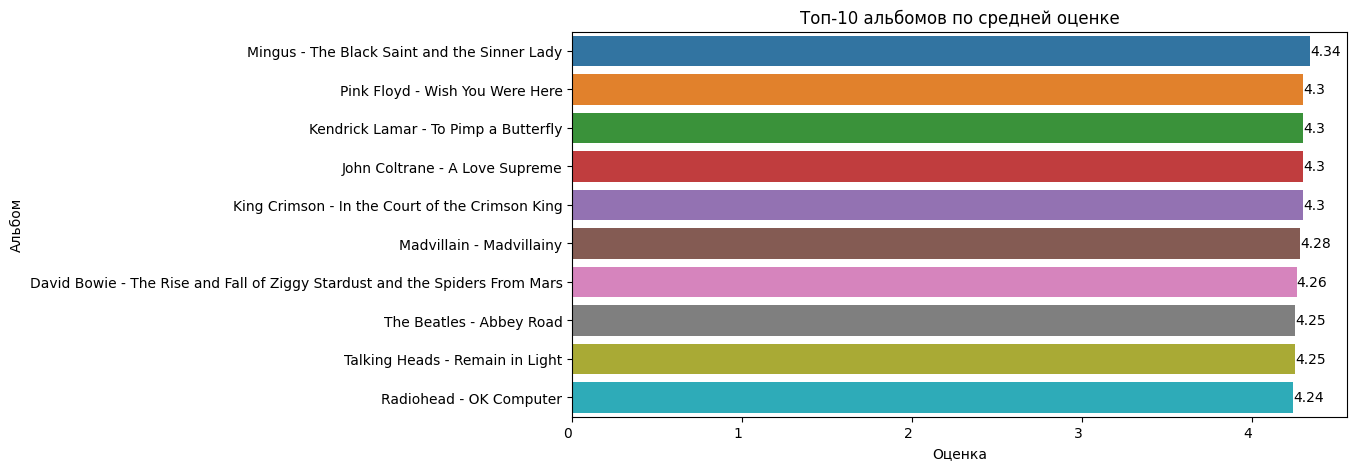

In [10]:
_, ax = plt.subplots(figsize=(10, 5))

data = df.sort_values('avg_rating', ascending = False)

sns.barplot(data = data.head(10), x = "avg_rating", y = 'full_name').set_title('Топ-10 альбомов по средней оценке')
ax.set_xticklabels(ax.get_xticklabels(), ha="right")
ax.bar_label(ax.containers[0]);
ax.set(xlabel='Оценка', ylabel='Альбом');

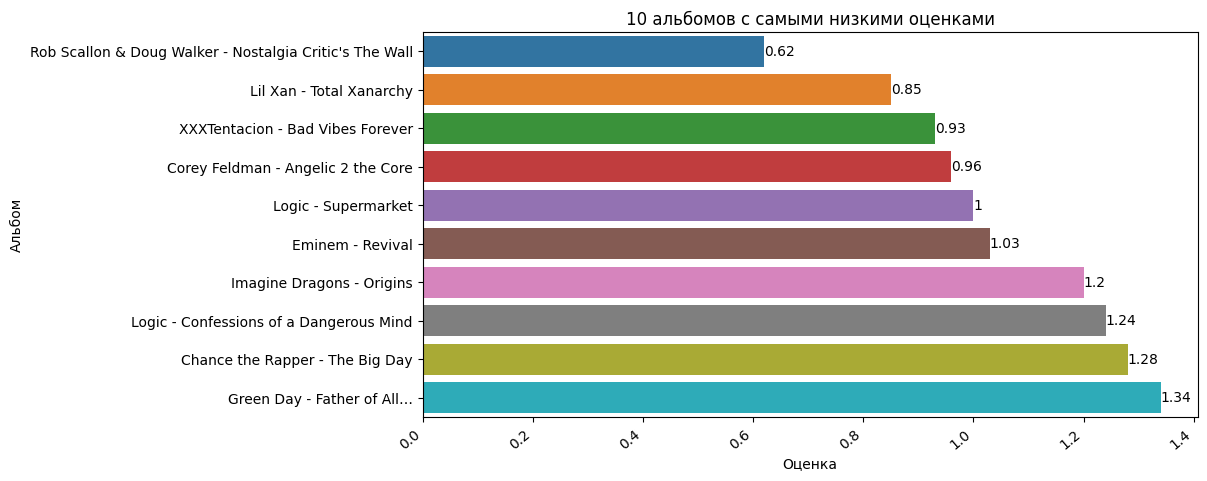

In [11]:
_, ax = plt.subplots(figsize=(10, 5))

data = df.sort_values('avg_rating', ascending = True)

sns.barplot(data = data.head(10), x = "avg_rating", y = 'full_name').set_title('10 альбомов с самыми низкими оценками')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha="right")
ax.bar_label(ax.containers[0]);
ax.set(xlabel='Оценка', ylabel='Альбом');

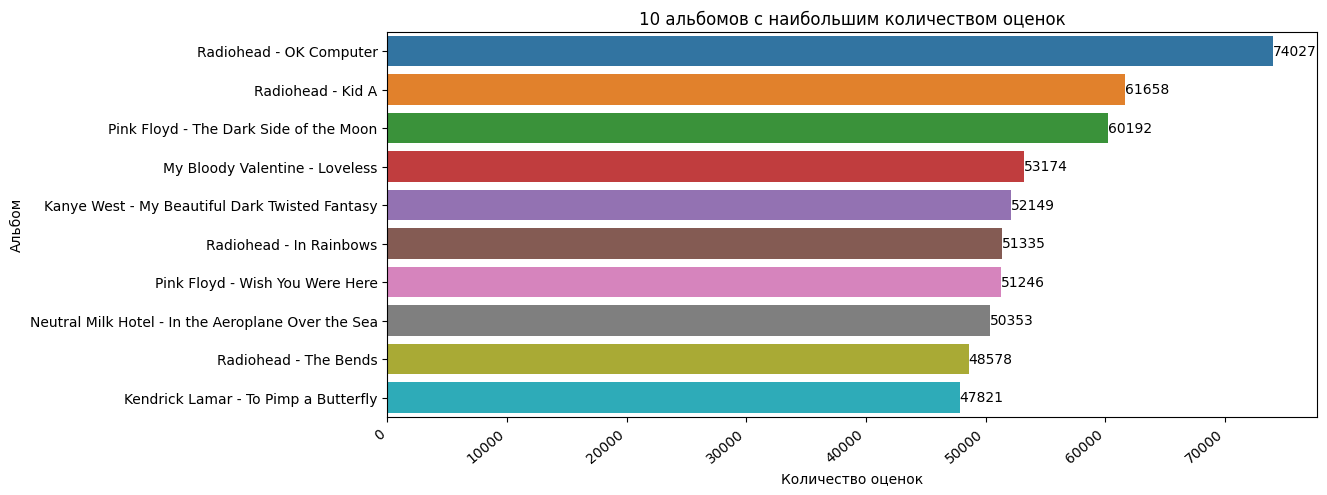

In [12]:
_, ax = plt.subplots(figsize=(12, 5))

data = df.sort_values('rating_count', ascending = False)

sns.barplot(data = data.head(10), x = "rating_count", y = 'full_name').set_title('10 альбомов с наибольшим количеством оценок')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = 'right')
ax.bar_label(ax.containers[0]);
ax.set(xlabel='Количество оценок', ylabel='Альбом');

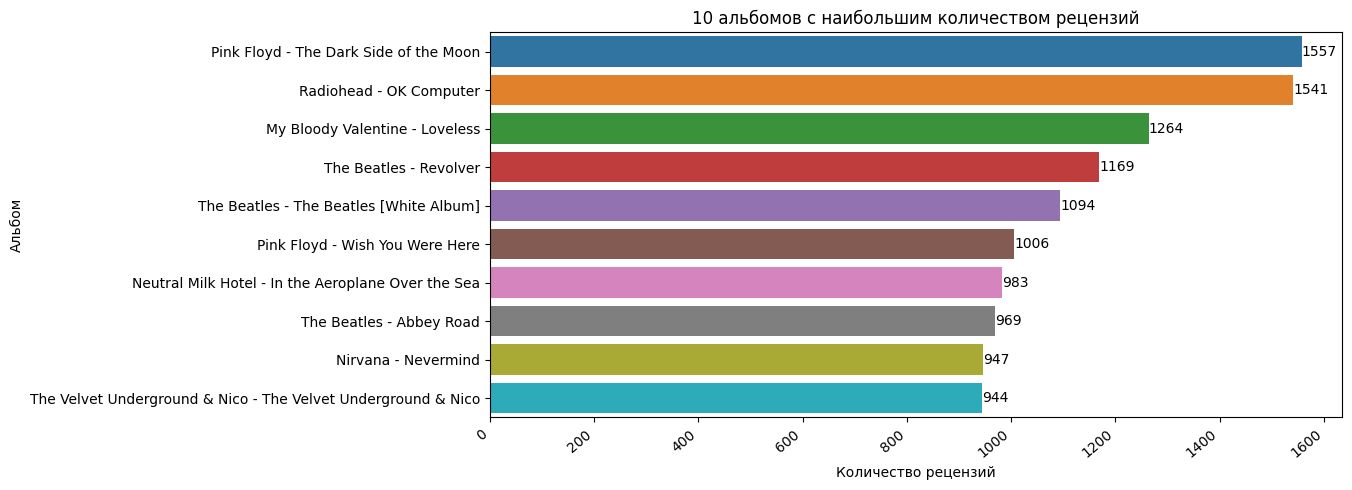

In [13]:
fig, ax = plt.subplots(figsize=(11, 5))

data = df.sort_values('review_count', ascending = False)

sns.barplot(data = data.head(10), x = "review_count", y = 'full_name').set_title('10 альбомов с наибольшим количеством рецензий')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = 'right')
ax.bar_label(ax.containers[0]);
ax.set(xlabel='Количество рецензий', ylabel='Альбом');

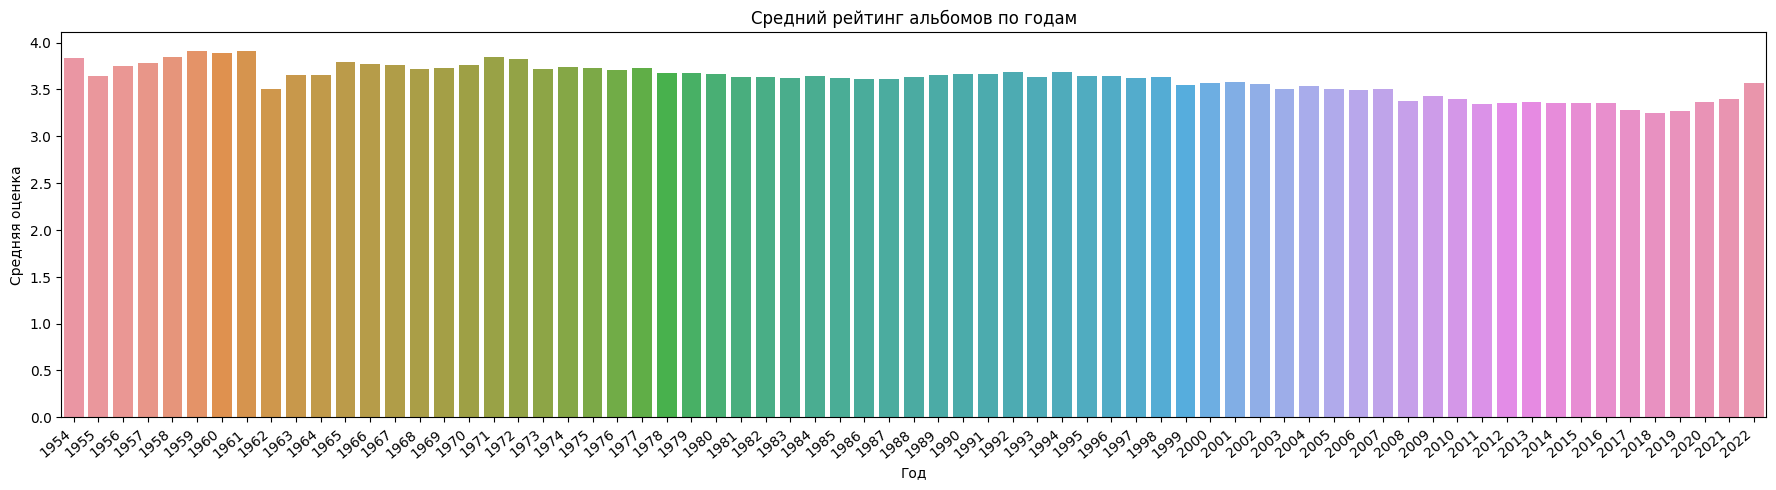

In [14]:
_, ax = plt.subplots(figsize=(22, 5))

data = df.groupby('release_year').mean('avg_rating')['avg_rating'].reset_index(level = 0 )

sns.barplot(data = data, x = "release_year", y = 'avg_rating').set_title('Средний рейтинг альбомов по годам')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha="right");
ax.set(xlabel='Год', ylabel='Средняя оценка');

### Альбомы с лучшими оценками по годам 

In [15]:
data = df.groupby('release_year').apply(lambda x : x.sort_values(by = 'avg_rating', ascending = False).head(1))[['artist_name', 'release_name', 'avg_rating']].reset_index(level=0)

fig = go.Figure(data=[go.Table(header = dict(values = list(data.columns), align='left'),
                    cells = dict(values = [data[i] for i in data.columns],           
                    align='left'))])
fig

## Анализ исполнителей 

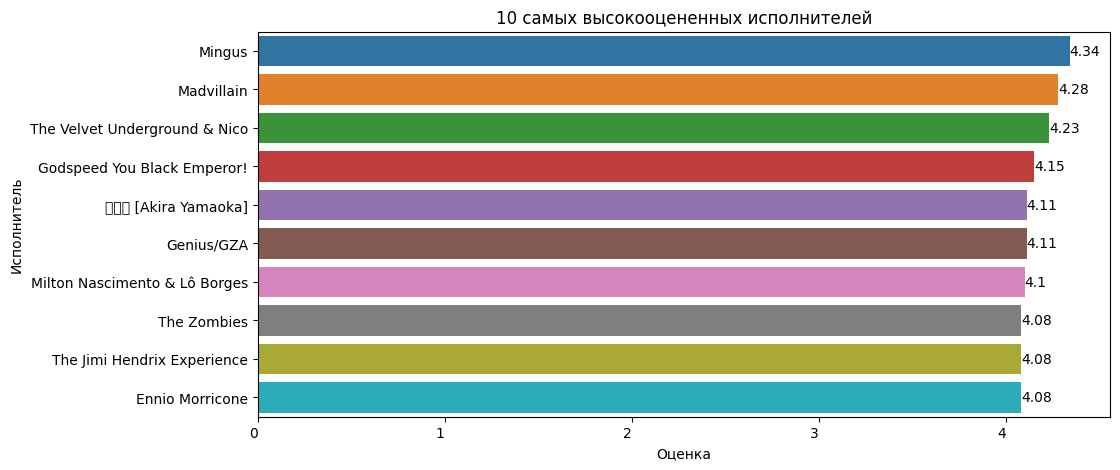

In [16]:
fig, ax = plt.subplots(figsize=(11, 5))

data = df[['artist_name', 'avg_rating']].groupby('artist_name').mean().round(2).sort_values('avg_rating', ascending = False)[['avg_rating']].reset_index(level=0)
sns.barplot(data = data.head(10), x = "avg_rating", y = 'artist_name').set_title('10 самых высокооцененных исполнителей')
ax.set_xticklabels(ax.get_xticklabels(), ha="right")
ax.bar_label(ax.containers[0]);
ax.set(xlabel='Оценка', ylabel='Исполнитель');

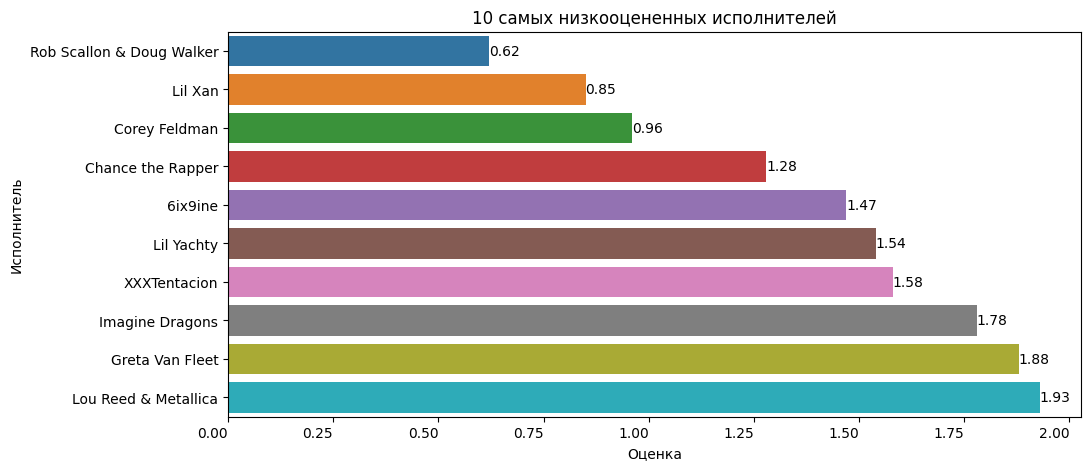

In [17]:
fig, ax = plt.subplots(figsize=(11, 5))

data = df[['artist_name', 'avg_rating']].groupby('artist_name').mean().round(2).sort_values('avg_rating', ascending = True)[['avg_rating']].reset_index(level=0)
sns.barplot(data = data.head(10), x = "avg_rating", y = 'artist_name').set_title('10 самых низкооцененных исполнителей')
ax.set_xticklabels(ax.get_xticklabels(), ha="right")
ax.bar_label(ax.containers[0]);
ax.set(xlabel='Оценка', ylabel='Исполнитель');

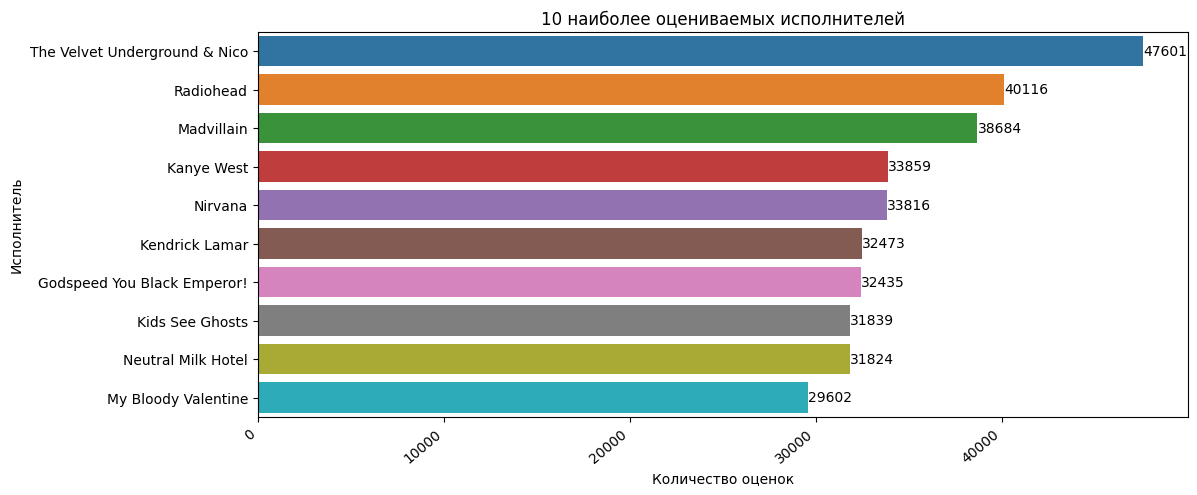

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))

data = df[['artist_name', 'rating_count']].groupby('artist_name').mean().round(0).sort_values('rating_count', ascending = False)[['rating_count']].reset_index(level=0)

sns.barplot(data = data.head(10), x = "rating_count", y = 'artist_name').set_title('10 наиболее оцениваемых исполнителей')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha="right")
ax.bar_label(ax.containers[0]);
ax.set(xlabel='Количество оценок', ylabel='Исполнитель');

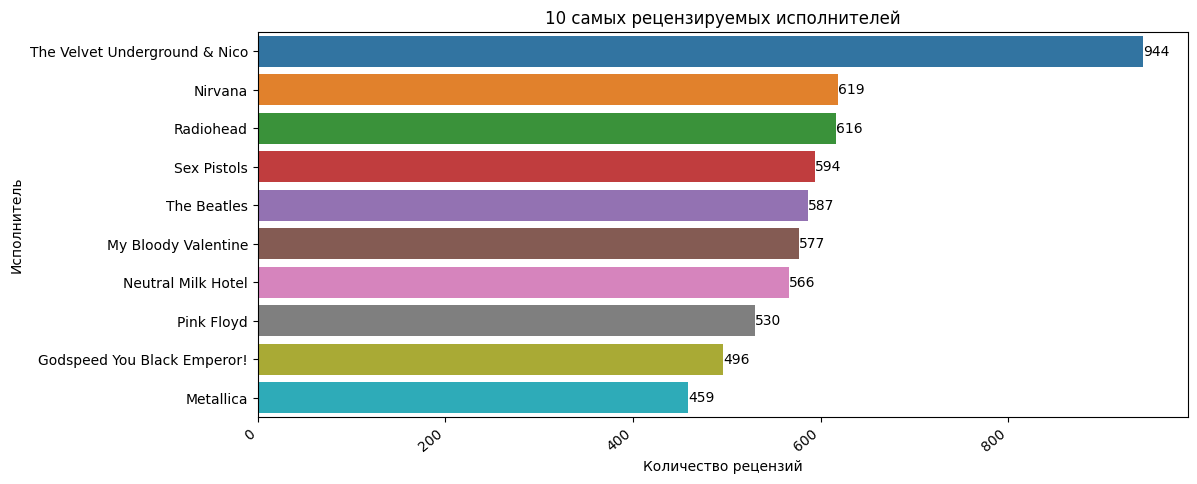

In [19]:
_, ax = plt.subplots(figsize=(12, 5))

data = df[['artist_name', 'review_count']].groupby('artist_name').mean().round(0).sort_values('review_count', ascending = False)[['review_count']].reset_index(level=0)

sns.barplot(data = data.head(10), x = "review_count", y = 'artist_name').set_title('10 самых рецензируемых исполнителей')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha="right")
ax.bar_label(ax.containers[0]);
ax.set(xlabel='Количество рецензий', ylabel='Исполнитель');

## Исполнитель с самой большой разницей между своим лучшим и своим худшим альбомами

In [20]:
datax = df[['artist_name', 'avg_rating']].groupby('artist_name').max()
datax['min_rating'] = df[['artist_name', 'avg_rating']].groupby('artist_name').min()
datax.rename(columns={"avg_rating": "max_rating"}, inplace=True)
datax['rating_delta'] = datax['max_rating'] - datax['min_rating']
datax.sort_values(by = 'rating_delta', ascending = False).head(1)

,max_rating,min_rating,rating_delta
artist_name,,,
Eminem,3.66,1.03,2.63


## Анализ жанров 

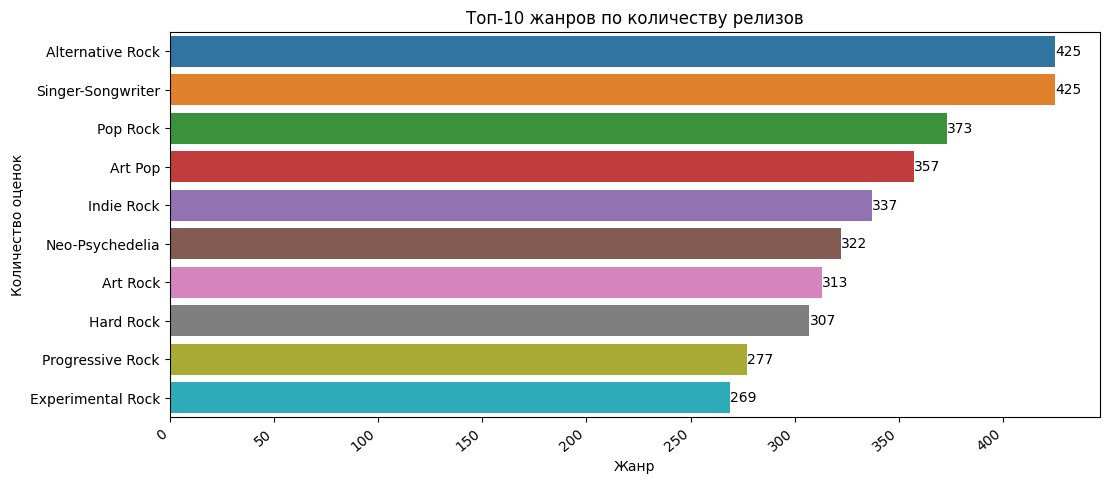

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))

data = df['genres'].explode().value_counts().reset_index()

sns.barplot(data = data.head(10), x = "count", y = 'genres').set_title('Топ-10 жанров по количеству релизов')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha="right")
ax.bar_label(ax.containers[0])
ax.set(xlabel='Жанр', ylabel='Количество оценок');

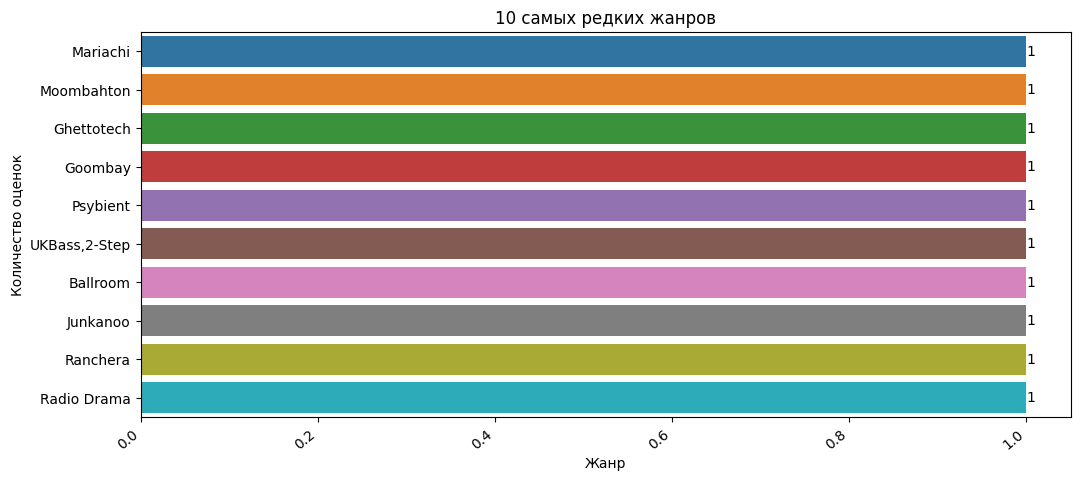

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))

data = df['genres'].explode().value_counts().reset_index(level = 0)

sns.barplot(data = data.tail(10), x = "count", y = 'genres').set_title('10 самых редких жанров')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = 'right')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Жанр', ylabel='Количество оценок');

In [23]:
genre_ratings_dict = {}


for index, album in df.iterrows():
    genres = album['genres']
    avg_rating = album['avg_rating']
    for genre in genres:
        if genre in genre_ratings_dict:
            genre_ratings_dict[genre].append(avg_rating)
        else:
            genre_ratings_dict[genre] = [avg_rating]
            
for genre, ratings in genre_ratings_dict.items():
    genre_ratings_dict[genre] = sum(ratings)/ float(len(ratings))
    
    
genre_ratings_dict = dict(sorted(genre_ratings_dict.items(), key=lambda item: item[1]))
data = pd.DataFrame(genre_ratings_dict, index=['Average Rating']).T.reset_index(level = 0).sort_values('Average Rating').rename(columns={"index": "Genre"})

keys = list(genre_ratings_dict.keys())[-10:]
keys.reverse()
vals = [float(genre_ratings_dict[k]) for k in keys]

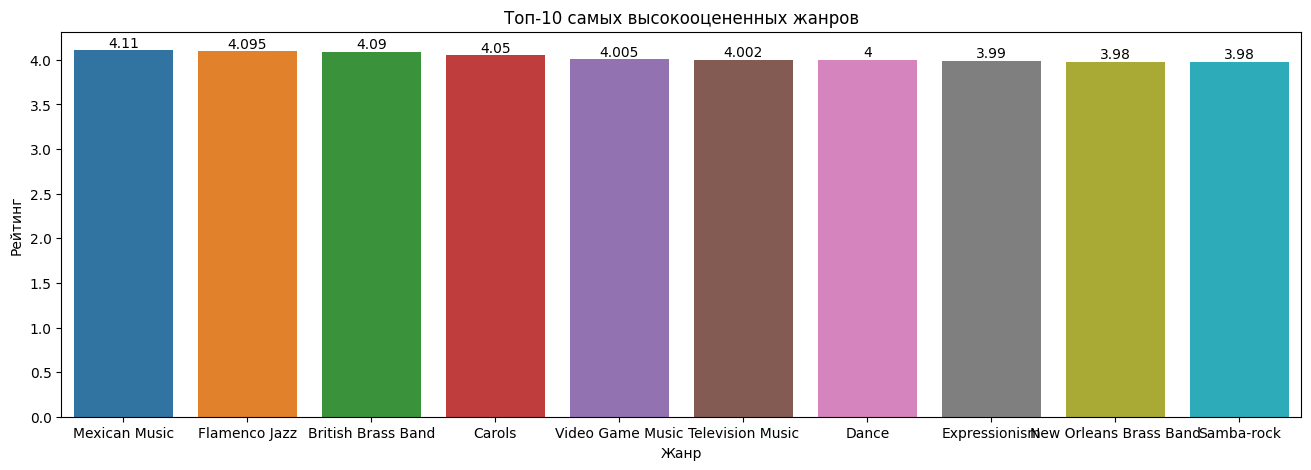

In [24]:
_, ax = plt.subplots(figsize=(16, 5))
ax = sns.barplot(x = keys, y = vals)
ax.bar_label(ax.containers[0])
ax.set_title('Топ-10 самых высокооцененных жанров')
ax.set(xlabel='Жанр', ylabel='Рейтинг');

Можно заметить, что в этом топе нет ни одного самого популярного жанра. Можно высказать предположение, что в этот топ попали жанры релизов с высокими оценками, но меньшим количеством этих оценок. Также средние оценки самых популярных жанров смещаются в сторону более низких в связи с бОльшим количеством релизов

**Note: Здесь и далее "популярный" будет означать "с большим количеством релизов" или подобное****Note: Здесь и далее "популярный" будет означать "с большим количеством релизов" или подобное**

### Самые популярные жанры по годам 

In [25]:
year_genre_map = {}

#Map genres to years
for index, album in df.iterrows():
    genres = album['genres']
    release_year = album['release_year']
    
    if release_year not in year_genre_map:
        year_genre_map[release_year] = []
        
    for genre in genres:
        year_genre_map[release_year].append(genre)      

year_genre_map_max = {}        
#Get max
for release_year, genres in year_genre_map.items():
    occurence_count = Counter(year_genre_map[release_year])
    year_genre_map_max[release_year] = occurence_count.most_common(1)[0][0]
    
data = pd.DataFrame(year_genre_map_max, index=['Самый популярный жанр']).T.reset_index(level = 0).sort_values('index').rename(columns={"index": 'Год'})



fig = go.Figure(data=[go.Table(header = dict(values = list(data.columns), align='left'),
                    cells = dict(values = [data[i] for i in data.columns],           
                    align='left'))])
fig

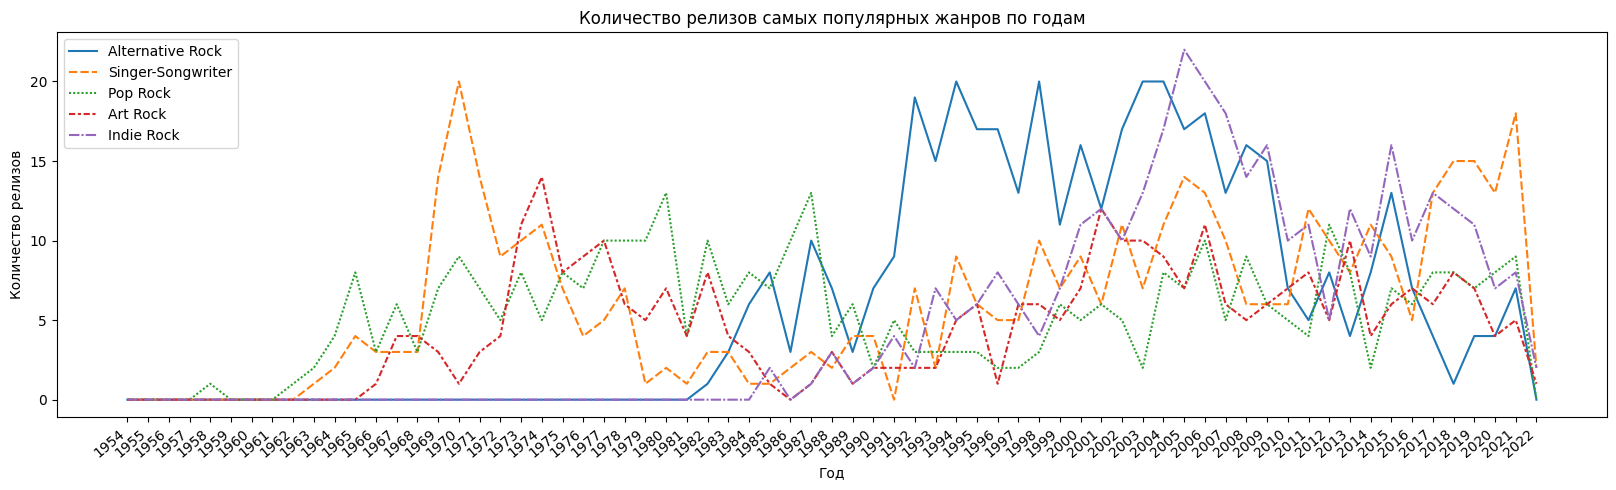

In [26]:
genre_keys = ['Alternative Rock', 'Singer-Songwriter', 'Pop Rock', 'Art Rock', 'Indie Rock']
genres_by_year = {}

for release_year, genres in year_genre_map.items():
    occurence_count = Counter(year_genre_map[release_year])
    genres_occurances = []
    
    for genre_key in genre_keys:
        n = occurence_count.get(genre_key)
        if n is None or math.isnan(n):
            n = 0
        genres_occurances.append(n)
    
    genres_by_year[release_year] = genres_occurances

data = pd.DataFrame(genres_by_year).T.sort_index()
data.columns = genre_keys

_, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = data)
ax.set_title('Количество релизов самых популярных жанров по годам')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = 'right')
ax.set(xlabel='Год', ylabel='Количество релизов');

## Анализ эпитетов 

[Text(0.5, 0, 'Эпитеты'), Text(0, 0.5, 'Количество')]

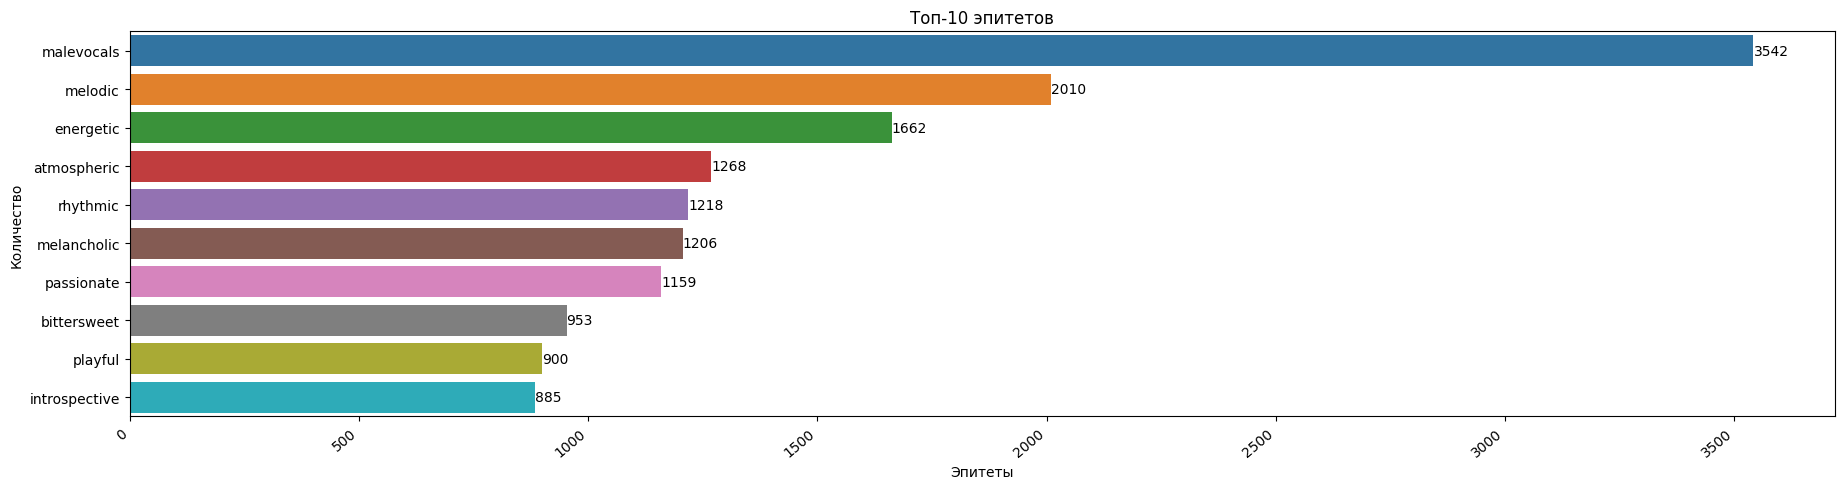

In [27]:
fig, ax = plt.subplots(figsize=(22, 5))

data = df['descriptors'].explode().value_counts().reset_index(level = 0)

sns.barplot(data = data.head(10), x = "count", y = 'descriptors').set_title('Топ-10 эпитетов')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha="right")
ax.bar_label(ax.containers[0])
ax.set(xlabel='Эпитеты', ylabel='Количество')

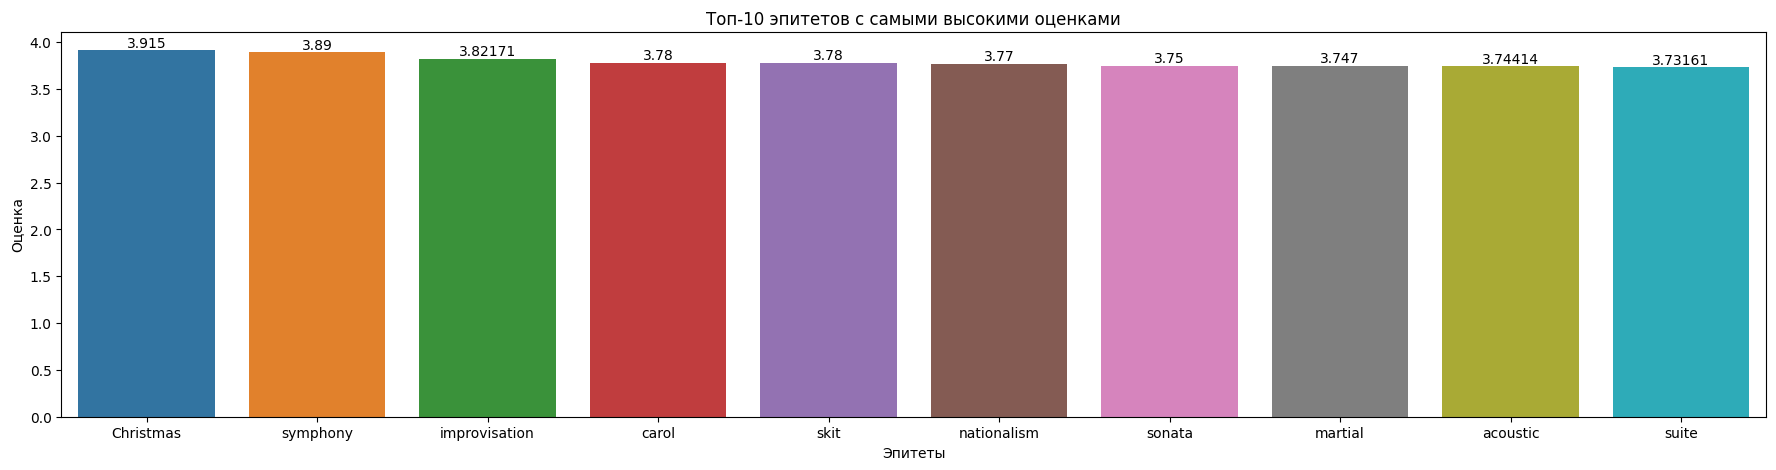

In [28]:
descriptor_ratings_dict = {}

#Map ratings to year
for index, album in df.iterrows():
    descriptors = album['descriptors']
    avg_rating = album['avg_rating']
    for descriptor in descriptors:
        if descriptor in descriptor_ratings_dict:
            descriptor_ratings_dict[descriptor].append(avg_rating)
        else:
            descriptor_ratings_dict[descriptor] = [avg_rating]     

#Get average
for descriptor, ratings in descriptor_ratings_dict.items():
    descriptor_ratings_dict[descriptor] = sum(ratings)/ float(len(ratings))
    
descriptor_ratings_dict = dict(sorted(descriptor_ratings_dict.items(), key=lambda item: item[1]))
data = pd.DataFrame(descriptor_ratings_dict, index=['Average Rating']).T.reset_index(level = 0).sort_values('index').rename(columns={"index": "Descriptor"})
keys = list(descriptor_ratings_dict.keys())[-10:]
keys.reverse()
vals = [float(descriptor_ratings_dict[k]) for k in keys]

_, ax = plt.subplots(figsize=(22, 5))
ax = sns.barplot(x = keys, y = vals)
ax.bar_label(ax.containers[0])
ax.set_title('Топ-10 эпитетов с самыми высокими оценками')
ax.set(xlabel='Эпитеты', ylabel='Оценка');

### Самые популярные эпитеты по годам 

In [29]:
year_descriptor_map = {}

#Map descriptors to years
for index, album in df.iterrows():
    descriptors = album['descriptors']
    release_year = album['release_year']
    
    if release_year not in year_descriptor_map:
        year_descriptor_map[release_year] = []
        
    for descriptor in descriptors:
        year_descriptor_map[release_year].append(descriptor)      

year_descriptor_map_max = {}        
#Get max
for release_year, descriptors in year_descriptor_map.items():
    occurence_count = Counter(year_descriptor_map[release_year])
    year_descriptor_map_max[release_year] = occurence_count.most_common(1)[0][0]
    
data = pd.DataFrame(year_descriptor_map_max, index=['Самый встречающийся эпитет']).T.reset_index(level = 0).rename(columns={"index": "Год"}).sort_values('Год')
fig = go.Figure(data=[go.Table(header = dict(values = list(data.columns), align='left'),
                    cells = dict(values = [data[i] for i in data.columns],           
                    align='left'))])
fig

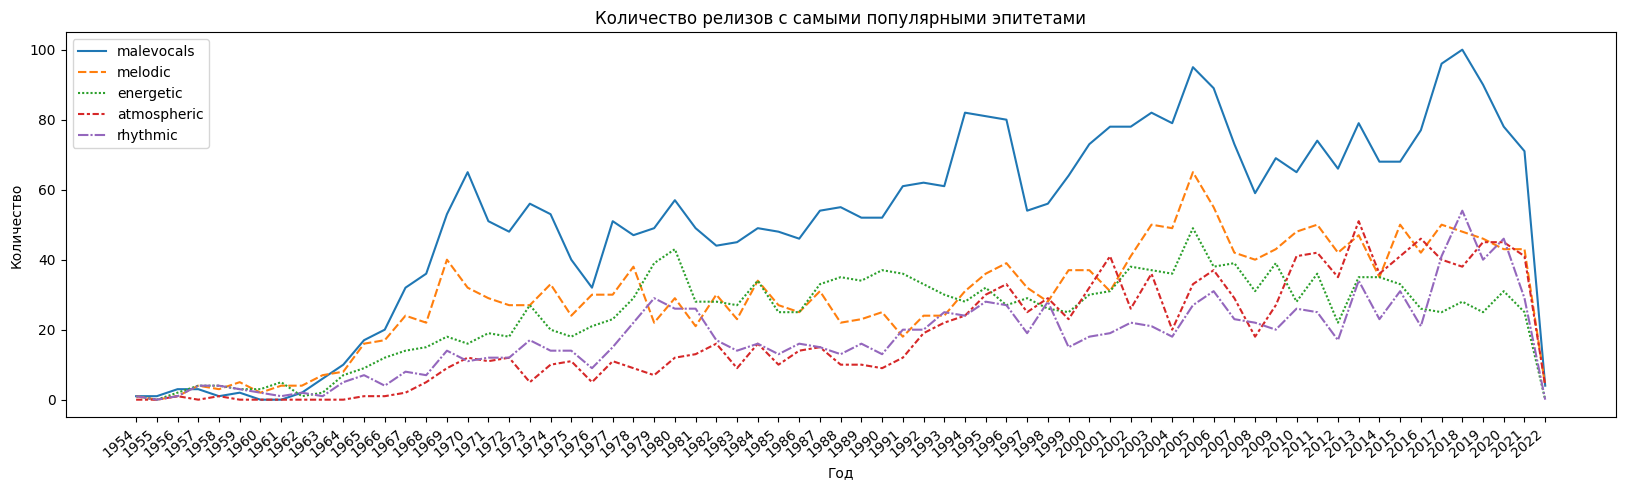

In [30]:
descriptor_keys = ['malevocals', 'melodic', 'energetic', 'atmospheric', 'rhythmic']
descriptors_by_year = {}

for release_year, descriptors in year_descriptor_map.items():
    occurence_count = Counter(year_descriptor_map[release_year])
    descriptors_occurances = []
    
    for descriptor_key in descriptor_keys:
        n = occurence_count.get(descriptor_key)
        if n is None or math.isnan(n):
            n = 0
        descriptors_occurances.append(n)
    
    descriptors_by_year[release_year] = descriptors_occurances

data = pd.DataFrame(descriptors_by_year).T.sort_index()
data.columns = descriptor_keys

_, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = data)
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha = 'right')
ax.set_title('Количество релизов с самыми популярными эпитетами')
ax.set(xlabel='Год', ylabel='Количество');

### Самые популярные эпитеты по жанрам 

In [31]:
genre_descriptor_map = {}

#Map descriptors to genre
for index, album in df.iterrows():
    descriptors = album['descriptors']
    genres = album['genres']
    
    for genre in genres:
        if genre not in genre_descriptor_map:
            genre_descriptor_map[genre] = []
        genre_descriptor_map[genre] += descriptors
        

genre_descriptor_top = {}        
#Get max
for genre, descriptors in genre_descriptor_map.items():
    occurence_count = Counter(genre_descriptor_map[genre])
    genre_descriptor_top[genre] = occurence_count.most_common(1)[0][0]
    
data = pd.DataFrame(genre_descriptor_top, index=['Самый встречающийся эпитет']).T.reset_index(level = 0).rename(columns={"index": "Жанр"}).sort_values('Жанр')
fig = go.Figure(data=[go.Table(header = dict(values = list(data.columns), align='left'),
                    cells = dict(values = [data[i] for i in data.columns],           
                    align='left'))])
fig

Что еще можно сделать:
* Разделить эпитеты на несколько категорий, например: "музыкальные" и "эмоциональные"
* Провести сравнение релизов других типов (EP и синглы)
* Провести анализ саундтреков отдельно от остальных релизов